In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Load the sales data
sales_data = pd.read_csv('sales_data.csv')

# Explore the data
print(sales_data.head())

   ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  \
0        10107               30      95.70                2  2871.00   
1        10121               34      81.35                5  2765.90   
2        10134               41      94.74                2  3884.34   
3        10145               45      83.26                6  3746.70   
4        10159               49     100.00               14  5205.27   

       ORDERDATE   STATUS  QTR_ID  MONTH_ID  YEAR_ID  ...  \
0   2/24/03 0:00  Shipped       1         2     2003  ...   
1    5/7/03 0:00  Shipped       2         5     2003  ...   
2    7/1/03 0:00  Shipped       3         7     2003  ...   
3   8/25/03 0:00  Shipped       3         8     2003  ...   
4  10/10/03 0:00  Shipped       4        10     2003  ...   

                    ADDRESSLINE1  ADDRESSLINE2           CITY STATE  \
0        897 Long Airport Avenue           NaN            NYC    NY   
1             59 rue de l'Abbaye           NaN          Re

In [3]:
# Feature engineering
sales_data['TOTAL_PRICE'] = sales_data['QUANTITYORDERED'] * sales_data['PRICEEACH']
sales_data['ORDER_MONTH'] = pd.to_datetime(sales_data['ORDERDATE']).dt.month
sales_data['ORDER_YEAR'] = pd.to_datetime(sales_data['ORDERDATE']).dt.year
sales_data['ORDER_DAY'] = pd.to_datetime(sales_data['ORDERDATE']).dt.day
sales_data['ORDER_DAY_OF_WEEK'] = pd.to_datetime(sales_data['ORDERDATE']).dt.dayofweek
sales_data['ORDER_WEEKDAY'] = pd.to_datetime(sales_data['ORDERDATE']).dt.dayofweek < 5  # Monday=0, Sunday=6
sales_data['NUMBER_OF_ORDERS'] = sales_data.groupby(['CUSTOMERNAME'])['ORDERNUMBER'].transform('count')
sales_data['SALES_PER_ORDER_LINE'] = sales_data['SALES'] / sales_data['ORDERLINENUMBER']

# Display the engineered features
print(sales_data.head())

   ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  \
0        10107               30      95.70                2  2871.00   
1        10121               34      81.35                5  2765.90   
2        10134               41      94.74                2  3884.34   
3        10145               45      83.26                6  3746.70   
4        10159               49     100.00               14  5205.27   

       ORDERDATE   STATUS  QTR_ID  MONTH_ID  YEAR_ID  ... CONTACTFIRSTNAME  \
0   2/24/03 0:00  Shipped       1         2     2003  ...             Kwai   
1    5/7/03 0:00  Shipped       2         5     2003  ...             Paul   
2    7/1/03 0:00  Shipped       3         7     2003  ...           Daniel   
3   8/25/03 0:00  Shipped       3         8     2003  ...            Julie   
4  10/10/03 0:00  Shipped       4        10     2003  ...            Julie   

   DEALSIZE TOTAL_PRICE ORDER_MONTH ORDER_YEAR ORDER_DAY ORDER_DAY_OF_WEEK  \
0     Small     2871

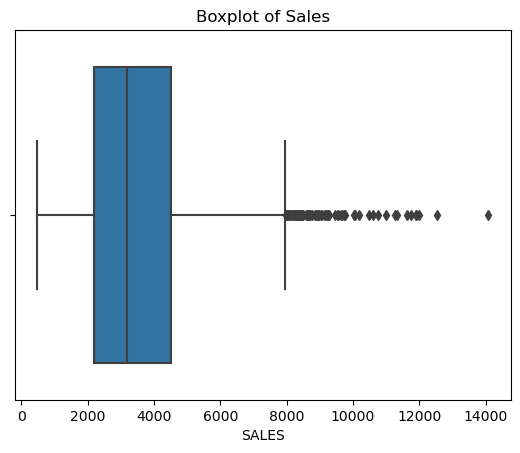

In [4]:
# Visualize the distribution of 'SALES' variable
sns.boxplot(x=sales_data['SALES'])
plt.title('Boxplot of Sales')
plt.show()

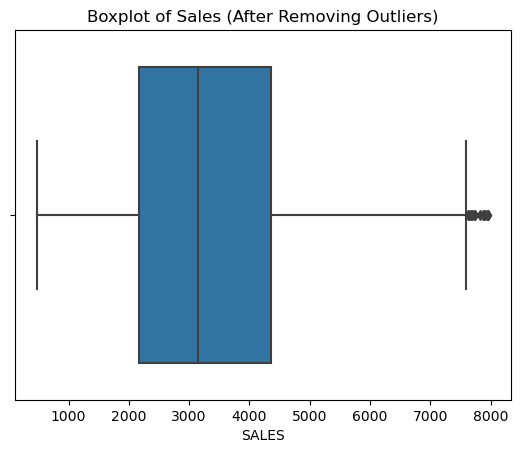

In [5]:
# Calculate the Interquartile Range (IQR)
Q1 = sales_data['SALES'].quantile(0.25)
Q3 = sales_data['SALES'].quantile(0.75)
IQR = Q3 - Q1

# Define the threshold for outliers
threshold = 1.5 * IQR

# Identify outliers
outliers = sales_data[(sales_data['SALES'] < Q1 - threshold) | (sales_data['SALES'] > Q3 + threshold)]

# Remove outliers from the dataset
cleaned_sales_data = sales_data[~sales_data['SALES'].isin(outliers['SALES'])]

# Visualize the distribution of 'SALES' variable after removing outliers
sns.boxplot(x=cleaned_sales_data['SALES'])
plt.title('Boxplot of Sales (After Removing Outliers)')
plt.show()
sales_data = cleaned_sales_data

In [6]:
# Data preprocessing
# Drop unnecessary columns
sales_data.drop(['ORDERNUMBER', 'ORDERDATE', 'STATUS', 'ADDRESSLINE1', 'ADDRESSLINE2', 'CITY', 'STATE', 'POSTALCODE', 'COUNTRY', 'TERRITORY', 'CONTACTLASTNAME', 'CONTACTFIRSTNAME', 'DEALSIZE'], axis=1, inplace=True)

# Handle missing values (if any)
sales_data.fillna(0, inplace=True)  # Replace missing values with 0 or use appropriate imputation strategy

# Encode categorical variables
label_encoder = LabelEncoder()
sales_data['CUSTOMERNAME'] = label_encoder.fit_transform(sales_data['CUSTOMERNAME'])

In [7]:
# Split data into training and testing sets
X = sales_data[['QUANTITYORDERED', 'PRICEEACH', 'TOTAL_PRICE', 'NUMBER_OF_ORDERS', 'SALES_PER_ORDER_LINE', 'ORDER_MONTH', 'ORDER_YEAR', 'ORDER_DAY', 'ORDER_DAY_OF_WEEK', 'ORDER_WEEKDAY']]  # Features
y = sales_data['SALES']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Train the model with linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('R^2 Score:', r2_score(y_test, y_pred))

Mean Squared Error: 476237.7210914936
R^2 Score: 0.8056803373458641


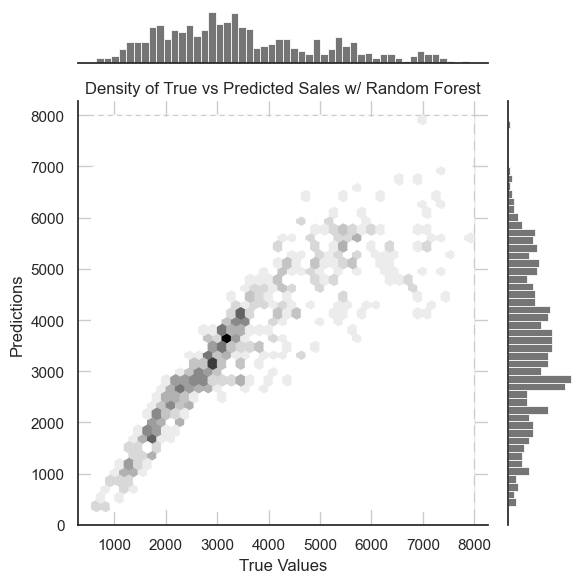

In [9]:
# Calculate the density of points
sns.set(style="white", color_codes=True)
sns.jointplot(x=y_test, y=y_pred, kind="hex", color="k", marginal_kws=dict(bins=50, fill=True, alpha=0.6), gridsize=40)

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Density of True vs Predicted Sales w/ Random Forest')
plt.grid(True)  # Add grid
plt.tight_layout()  # Adjust layout to prevent overlapping titles
plt.show()

In [10]:
# Train the model (Random Forest Regressor)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('R^2 Score:', r2_score(y_test, y_pred))

Mean Squared Error: 362733.53417668067
R^2 Score: 0.8519935425673402


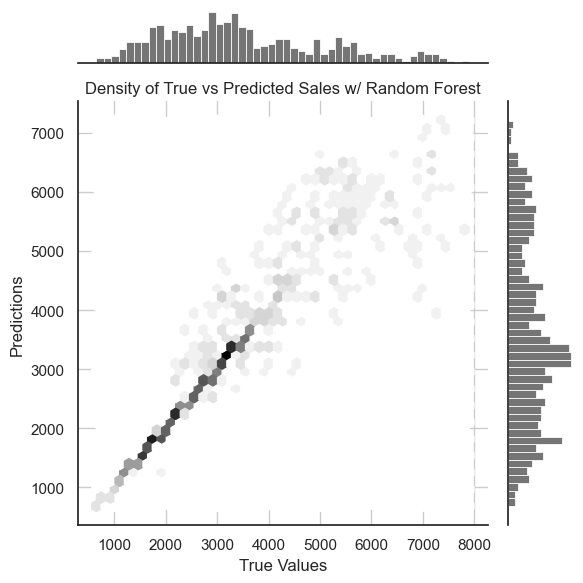

In [11]:
# Calculate the density of points
sns.set(style="white", color_codes=True)
sns.jointplot(x=y_test, y=y_pred, kind="hex", color="k", marginal_kws=dict(bins=50, fill=True, alpha=0.6), gridsize=40)

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Density of True vs Predicted Sales w/ Random Forest')
plt.grid(True)  # Add grid
plt.tight_layout()  # Adjust layout to prevent overlapping titles
plt.show()